Read and plot a variable from the Northeast pacific hindcast from Google Cloud Storage

In [1]:
import xarray as xr
import cf_xarray # This is a wrapper for xarray that allows access to the data through standard coordinate names
import fsspec
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

In [42]:
fs = fsspec.filesystem(
    "reference", 
    fo='gcs://noaa-oar-cefi-regional-mom6/northeast_pacific/full_domain/hindcast/daily/regrid/r20241015/tos.nep.full.hcast.daily.regrid.r20241015.199301-201912.json',
    remote_protocol="gcs", 
    remote_options={"anon":True},
    skip_instance_cache=True,
    target_options={"anon": True}
)
m = fs.get_mapper()
tos = xr.open_dataset(m, engine='zarr', consolidated=False)
tos

<xarray.Dataset> Size: 11GB
Dimensions:  (lat: 815, lon: 341, time: 9861)
Coordinates:
  * lat      (lat) float64 7kB 10.81 10.89 10.98 11.07 ... 80.55 80.63 80.72
  * lon      (lon) float64 3kB 156.9 157.2 157.5 157.8 ... 254.4 254.7 255.0
  * time     (time) datetime64[ns] 79kB 1993-01-01T12:00:00 ... 2019-12-31T12...
Data variables:
    tos      (time, lat, lon) float32 11GB ...
Attributes: (12/27)
    NumFilesInSet:          1
    associated_files:       areacello: 19930101.ocean_static.nc
    cefi_archive_version:   /archive/e1n/fre/cefi/NEP/2024_08/NEP10k_082024_c...
    cefi_aux:               Postprocessed Data : regrid to regular grid
    cefi_data_doi:          10.5281/zenodo.13936240
    cefi_date_range:        199301-201912
    ...                     ...
    cefi_subdomain:         full
    cefi_variable:          tos
    external_variables:     areacello
    grid_tile:              N/A
    grid_type:              regular
    title:                  NEP10k_082024_clean_spinup

In [44]:
slice_tos = tos.sel(time="2003-06-01T12:00:00")
slice_tos.cf

Coordinates:
             CF Axes: * X: ['lon']
                      * Y: ['lat']
                        T: ['time']
                        Z: n/a

      CF Coordinates: * longitude: ['lon']
                      * latitude: ['lat']
                        time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names: * latitude: ['lat']
                      * longitude: ['lon']

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area, volume: n/a

      Standard Names:   sea_surface_temperature: ['tos']

              Bounds:   n/a

       Grid Mappings:   n/a

In [46]:
xmin = slice_tos.cf['longitude'].min()
xmax = slice_tos.cf['longitude'].max()
ymin = slice_tos.cf['latitude'].min()
ymax = slice_tos.cf['latitude'].max()
aspect = (xmax-xmin)/(ymax-ymin)

In [47]:
slice_tos

<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 815, lon: 341)
Coordinates:
  * lat      (lat) float64 7kB 10.81 10.89 10.98 11.07 ... 80.55 80.63 80.72
  * lon      (lon) float64 3kB 156.9 157.2 157.5 157.8 ... 254.4 254.7 255.0
    time     datetime64[ns] 8B 2003-06-01T12:00:00
Data variables:
    tos      (lat, lon) float32 1MB ...
Attributes: (12/27)
    NumFilesInSet:          1
    associated_files:       areacello: 19930101.ocean_static.nc
    cefi_archive_version:   /archive/e1n/fre/cefi/NEP/2024_08/NEP10k_082024_c...
    cefi_aux:               Postprocessed Data : regrid to regular grid
    cefi_data_doi:          10.5281/zenodo.13936240
    cefi_date_range:        199301-201912
    ...                     ...
    cefi_subdomain:         full
    cefi_variable:          tos
    external_variables:     areacello
    grid_tile:              N/A
    grid_type:              regular
    title:                  NEP10k_082024_clean_spinup

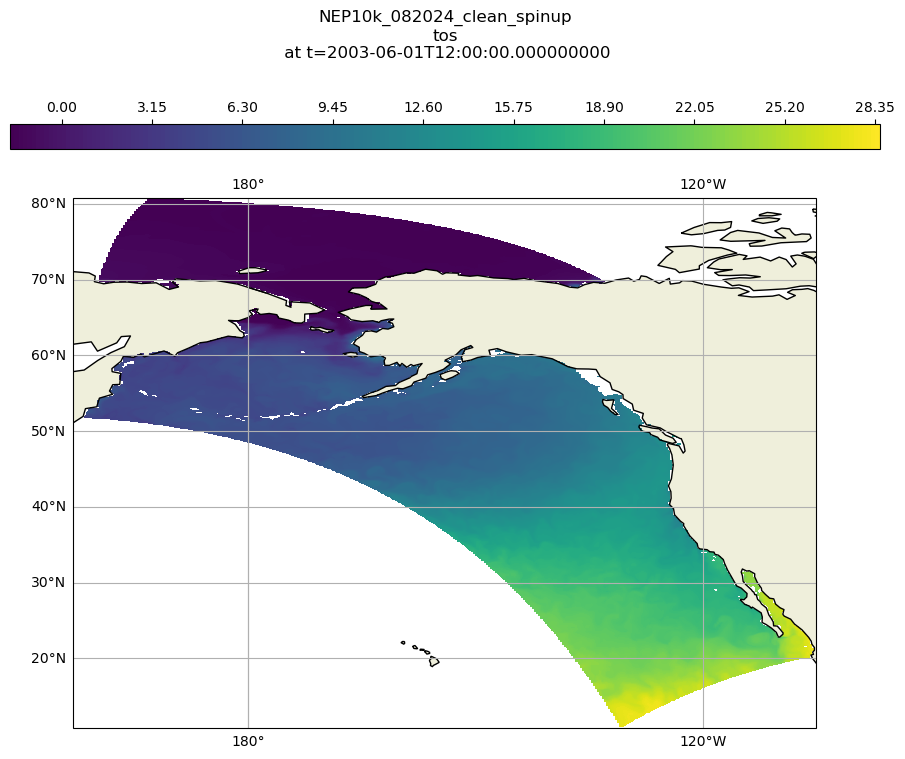

In [52]:
plt.figure(figsize=(8*aspect,8))
proj = ccrs.PlateCarree(central_longitude=-180)
proj180 = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.set_extent([xmin, xmax, ymin, ymax], crs=proj180)
# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
ct = ax.contourf(slice_tos.cf['longitude'], slice_tos.cf['latitude'], slice_tos['tos'], levels=255, transform=proj180, cmap="viridis")
plt.colorbar(ct, orientation='horizontal',pad=0.08, aspect=35, fraction=.06, location='top')
plt.title(str(slice_tos.attrs['title']) + '\ntos\n at t=' + str(slice_tos['time'].values), y=1.25)
plt.show()